In [61]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.subplots as sp
import networkx as nx
import numpy as np
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Read excel file
def read_excel(file, sheet_name=0):
    """
    Reads an Excel file and returns a DataFrame from the specified sheet.

    Parameters:
    - file (str): Path to the Excel file.
    - sheet_name (str or int): Sheet name or index to read from. Default is the first sheet.

    Returns:
    - pd.DataFrame: DataFrame containing the data from the specified sheet.
    """
    df = pd.read_excel(file, sheet_name=sheet_name)
    df = pd.DataFrame(df)
    return df

# Read csv file
def read_csv(file):
    df = pd.read_csv(file)
    df = pd.DataFrame(df)
    return df


# Clean data
columns = ['ledger_fee_id', 'employment', 'phone_number', 'success_redirect_url', 'given_name', 
            'business_nature', 'account_details', 'gender', 'expires_at', 'client', 'fee', 
            'hashed_phone_number', 'refunded_amount', 'payment_channel_transaction_id', 
            'linked_account_id', 'is_otp_required', 'otp_mobile_number', 'settlement_date', 
            'business_type', 'failure_code', 'callback_url', 'status', 'channel_account_reference', 
            'updated', 'device_fingerprint', 'date_of_birth', 'description', 'domicile_of_registration', 
            'version', 'checkout_url', 'vat', 'trading_name', 'client_type', 'id', 'status2', 
            'payment_channel_verification_id', 'meta', 'transacting_entity', 'internal_metadata', 
            'idempotency_key', 'nationality', 'ledger_transaction_id', 'business_name', 
            'connector_metadata', 'installment', 'time', 'given_names', 'business_id', 'basket', 
            'domicile_country', 'end_customer_id', 'created', 'middle_name', 'amount', 'email', 
            'channel_code', 'client_reference', 'ledger_payment_id', 'failure_redirect_url', 
            'given_names_non_roman', 'customer_id', 'required_action', 'surname', 
            'surname_non_roman', 'payment_channel_reference_id', 'entity', 'type', 'account_hash', 
            'date_of_registration', 'business_domicile', 'occupation', 'date_of_account_registration', 
            'ledger_settlement_id', 'dt', 'mother_maiden_name', 'account_type', 'bank_acc', 
            'otp_expiration_timestamp', 'place_of_birth', 'metadata', 'business_subtype', 
            'currency', 'payment_method_id', 'mobile_number', 'reference_id', 'enable_otp']

def preprocess_dataframe(df, colums_to_keep=columns):
    """
    Preprocesses a DataFrame by:
    - Making column names lowercase
    - Converting all text to lowercase
    - Replacing spaces with underscores in both column names and text values
    - Removing columns with all values missing
    - Keeping only specified columns

    Parameters:
    - df (pd.DataFrame): The DataFrame to preprocess.
    - colums_to_keep (list): List of columns to keep in the DataFrame.

    Returns:
    - pd.DataFrame: The preprocessed DataFrame.
    """
    # Convert column names to lowercase
    df.columns = df.columns.str.lower()
    
    # Convert entire table to lowercase
    df = df.apply(lambda x: x.astype(str).str.lower())
    
    # Replace spaces with underscores in column names and text values
    df.columns = df.columns.str.replace(' ', '_')
    df = df.apply(lambda x: x.str.replace(' ', '_'))
    
    # Keep only specified columns
    df = df[colums_to_keep]   
    
    # Replace 'nan' strings with actual NaN values
    df.replace('nan', np.nan, inplace=True)
    
    # Remove columns with all values missing
    df = df.dropna(axis=1, how='all')
    


    return df

def describe_dataframe(df):
    """
    Provides a description of the DataFrame including:
    - Number of rows and columns
    - Column names and data types
    - Basic statistics (for numeric columns)
    - A preview of the first few rows
    - Number of NaN values per column, sorted by highest to lowest

    Parameters:
    - df (pd.DataFrame): The DataFrame to describe.

    Returns:
    - None
    """
    if df.empty:
        print("The DataFrame is empty.")
        return
    
    # Number of rows and columns
    num_rows, num_cols = df.shape
    print(f"Number of rows: {num_rows}")
    print(f"Number of columns: {num_cols}")
    
    # Column names and data types
    print("\nColumn names and data types:")
    print(df.dtypes)
    
    # Number of NaN values per column, sorted by highest to lowest
    nan_counts = df.isna().sum().sort_values(ascending=False)
    print("\nNumber of NaN values per column (sorted by highest to lowest):")
    print(nan_counts)
    
    # Basic statistics for numeric columns
    if not df.select_dtypes(include=[np.number]).empty:
        print("\nBasic statistics for numeric columns:")
        print(df.describe(include=[np.number]))
    else:
        print("\nNo numeric columns available for basic statistics.")
    
    # Preview of the first few rows
    print("\nPreview of the first few rows:")
    print(df.head())


def factorize_and_map(df, token_mapping):
    """
    Factorizes columns in the DataFrame and applies token mapping.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame to preprocess.
    - token_mapping (dict): Dictionary with column names as keys and token prefixes as values.
    
    Returns:
    - pd.DataFrame: The DataFrame with factorized and token-mapped columns.
    - dict: Dictionary containing the factorized values to original values mappings for each column.
    - dict: Dictionary containing token-mapped values to original values mappings for each column.
    """
    # Dictionary to store factorized to original mappings
    factorized_to_original = {}
    token_to_original = {}
    
    # Factorize and apply token mapping
    for col, prefix in token_mapping.items():
        if col in df.columns:
            # Factorize the column and store the mapping
            factorized_values, original_values = pd.factorize(df[col])
            factorized_to_original[col] = dict(enumerate(original_values))
            
            # Create token to original mapping
            token_mapped_values = {f"{prefix}{i}": original_values[i] for i in range(len(original_values))}
            token_to_original[col] = token_mapped_values
            
            # Apply factorization
            df[col] = factorized_values
            
            # Apply token mapping
            df[col] = df[col].apply(lambda x: f"{prefix}{x}")
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
    
    return df, factorized_to_original, token_to_original

def get_original_value_from_token(token_mapped_value, token_to_original):
    """
    Retrieves the original value from a token-mapped value using the global token_to_original mapping.
    
    Parameters:
    - token_mapped_value (str): The token-mapped value to recover.
    - token_to_original (dict): Dictionary containing token-mapped values to original values mappings for each column.
    
    Returns:
    - str: The original value corresponding to the token-mapped value.
    """
    for column_name, mapping in token_to_original.items():
        if token_mapped_value in mapping:
            return mapping[token_mapped_value]
    raise ValueError(f"Token-mapped value '{token_mapped_value}' not found in any column.")


def create_and_plot_network(df, node_cols, edge_cols, color_col):
    """
    Creates and plots a network graph from a DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - node_cols (list): List of node columns (up to 2) to be used in the graph.
    - edge_cols (list): List of edge columns (should be exactly one column for weights).
    - color_col (str): Column name used for node colors.
    
    Returns:
    - G (nx.Graph): The created network graph.
    """
    G = nx.Graph()
    
    # Add nodes
    for node_col in node_cols:
        for value in df[node_col].unique():
            G.add_node(value, node_type=node_col, email=df[df[node_col] == value][color_col].iloc[0])
    
    # Add edges
    if len(edge_cols) != 1:
        raise ValueError("Exactly one edge column is required for weights.")
    
    weight_col = edge_cols[0]
    for _, row in df.iterrows():
        G.add_edge(row[node_cols[0]], row[node_cols[1]], weight=row[weight_col])
    
    # Set node colors based on email
    if color_col:
        unique_values = df[color_col].unique()
        color_map = plt.get_cmap('hsv')
        value_to_color = {value: color_map(i / len(unique_values)) for i, value in enumerate(unique_values)}
        node_colors = [value_to_color[G.nodes[node].get(color_col, 'grey')] for node in G.nodes()]
    else:
        node_colors = ['grey'] * len(G.nodes())
    
    # Set node shapes based on node types
    unique_node_types = set(nx.get_node_attributes(G, 'node_type').values())
    shape_map = {node_type: shape for node_type, shape in zip(unique_node_types, ['o', '^'])}
    
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(24, 16))
    
    # Draw the graph
    pos = nx.spring_layout(G)
    
    # Draw nodes with different shapes and colors
    for node_type, shape in shape_map.items():
        shape_nodes = [node for node in G.nodes() if G.nodes[node].get('node_type') == node_type]
        nx.draw_networkx_nodes(G, pos, 
                                nodelist=shape_nodes,
                                node_color=[value_to_color[G.nodes[node].get(color_col, 'grey')] for node in shape_nodes],
                                node_shape=shape,
                                label=node_type,
                                ax=ax)
    
    # Draw edges and labels
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', width=2, style='dashed')
    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)
    
    edge_weights = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights, ax=ax)
    
    ax.set_title("Network Graph")
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return G

def plot_subgraphs(G, nodes_per_page=6, node_size=70, num_hops=2, 
                    node_font_size=6, title_font_size=10, 
                    edge_label_font_size=6, figsize_per_row=5, max_figures=10):
    """
    Plots subgraphs of a network graph, with settings for pagination, node size, 
    font sizes, and figure size. Limits the number of figures generated.

    Parameters:
    - G (nx.Graph): The graph to plot.
    - nodes_per_page (int): Number of nodes per page.
    - node_size (int): Size of nodes.
    - num_hops (int): Number of hops to include in the neighborhood.
    - node_font_size (int): Font size for node labels.
    - title_font_size (int): Font size for subplot titles.
    - edge_label_font_size (int): Font size for edge labels.
    - figsize_per_row (int): Figure size per row for the subplot grid.
    - max_figures (int): Maximum number of figures to generate.
    """
    
    # Extract node colors and shapes
    email_to_color = {node: plt.colormaps['hsv'](i / len(set(nx.get_node_attributes(G, 'email').values())))
                        for i, node in enumerate(set(nx.get_node_attributes(G, 'email').values()))}
    
    # Sort nodes by degree (highest to lowest)
    sorted_nodes = sorted(G.nodes(), key=lambda node: G.degree(node), reverse=True)
    
    # Pagination settings
    total_pages = (len(sorted_nodes) + nodes_per_page - 1) // nodes_per_page
    total_pages = min(total_pages, max_figures)
    
    for page in range(total_pages):
        start_idx = page * nodes_per_page
        end_idx = min(start_idx + nodes_per_page, len(sorted_nodes))
        nodes_to_plot = sorted_nodes[start_idx:end_idx]
        
        n = len(nodes_to_plot)
        cols = 3
        rows = (n + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(15, figsize_per_row * rows))
        axes = axes.flatten()

        # Plot each node with its neighborhood
        for i, node in enumerate(nodes_to_plot):
            # Extract neighborhood
            subgraph_nodes = nx.single_source_shortest_path_length(G, node, cutoff=num_hops).keys()
            subgraph = G.subgraph(subgraph_nodes)

            # Set subgraph node colors and shapes
            sub_node_colors = [email_to_color.get(subgraph.nodes[n]['email'], 'grey') for n in subgraph.nodes()]
            sub_node_shapes = ['o' if subgraph.nodes[n]['node_type'] == 'account' else '^' for n in subgraph.nodes()]

            pos = nx.spring_layout(subgraph)

            # Draw subgraph
            ax = axes[i]
            nx.draw(subgraph, pos, ax=ax, node_color=sub_node_colors, node_size=node_size, with_labels=True, font_size=node_font_size)
            
            # Draw account nodes (circles)
            nx.draw_networkx_nodes(subgraph, pos, 
                                    node_color=[color for n, color in zip(subgraph.nodes(), sub_node_colors) if subgraph.nodes[n]['node_type'] == 'account'],
                                    node_shape='o',
                                    nodelist=[n for n in subgraph.nodes() if subgraph.nodes[n]['node_type'] == 'account'],
                                    node_size=node_size,
                                    ax=ax)

            # Draw customer nodes (triangles)
            nx.draw_networkx_nodes(subgraph, pos, 
                                    node_color=[color for n, color in zip(subgraph.nodes(), sub_node_colors) if subgraph.nodes[n]['node_type'] == 'customer'],
                                    node_shape='^',
                                    nodelist=[n for n in subgraph.nodes() if subgraph.nodes[n]['node_type'] == 'customer'],
                                    node_size=node_size,
                                    ax=ax)

            edge_weights = nx.get_edge_attributes(subgraph, 'weight')
            nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_weights, ax=ax, font_size=edge_label_font_size)

            ax.set_title(f"Neighborhood (Hops: {num_hops}) of Node {node}", fontsize=title_font_size)
            ax.axis('off')

        # Hide unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()


In [62]:
# Read the data
df1 = read_excel('idtobank.xlsx')
df2 = read_excel('hashtoid.xlsx')
fraud_data = read_excel('fraud.xlsx', sheet_name='Detail data')

df1 = preprocess_dataframe(df1)
df2 = preprocess_dataframe(df2)

df = pd.concat([df1, df2], ignore_index=True)
fraud_ids = fraud_data['customer_id'].unique()
df['is_fraud'] = df['customer_id'].isin(fraud_ids).astype(object)


print(df['is_fraud'])

describe_dataframe(df)

0        True
1        True
2        True
3        True
4        True
        ...  
4058    False
4059    False
4060    False
4061    False
4062    False
Name: is_fraud, Length: 4063, dtype: object
Number of rows: 4063
Number of columns: 57

Column names and data types:
success_redirect_url               object
account_details                    object
expires_at                         object
client                             object
fee                                object
refunded_amount                    object
payment_channel_transaction_id     object
linked_account_id                  object
is_otp_required                    object
otp_mobile_number                  object
settlement_date                    object
failure_code                       object
callback_url                       object
status                             object
channel_account_reference          object
updated                            object
version                            object
checkout_url   

In [63]:
# Dictionary for token mapping
token_mapping = {
    'account_hash': 'a_h ',
    'customer_id': 'c_id ',
    'email': 'e'
}

# Factorize and map columns
df, factorized_to_original, token_to_original = factorize_and_map(df, token_mapping)


# Example: Get original value from token-mapped value
get_original_value_from_token('a_h 0', token_to_original)

'b15dee28891e6e8b2061540556bd8e6711e3a14d2c755ea4b19ce0a9ffe48c79'

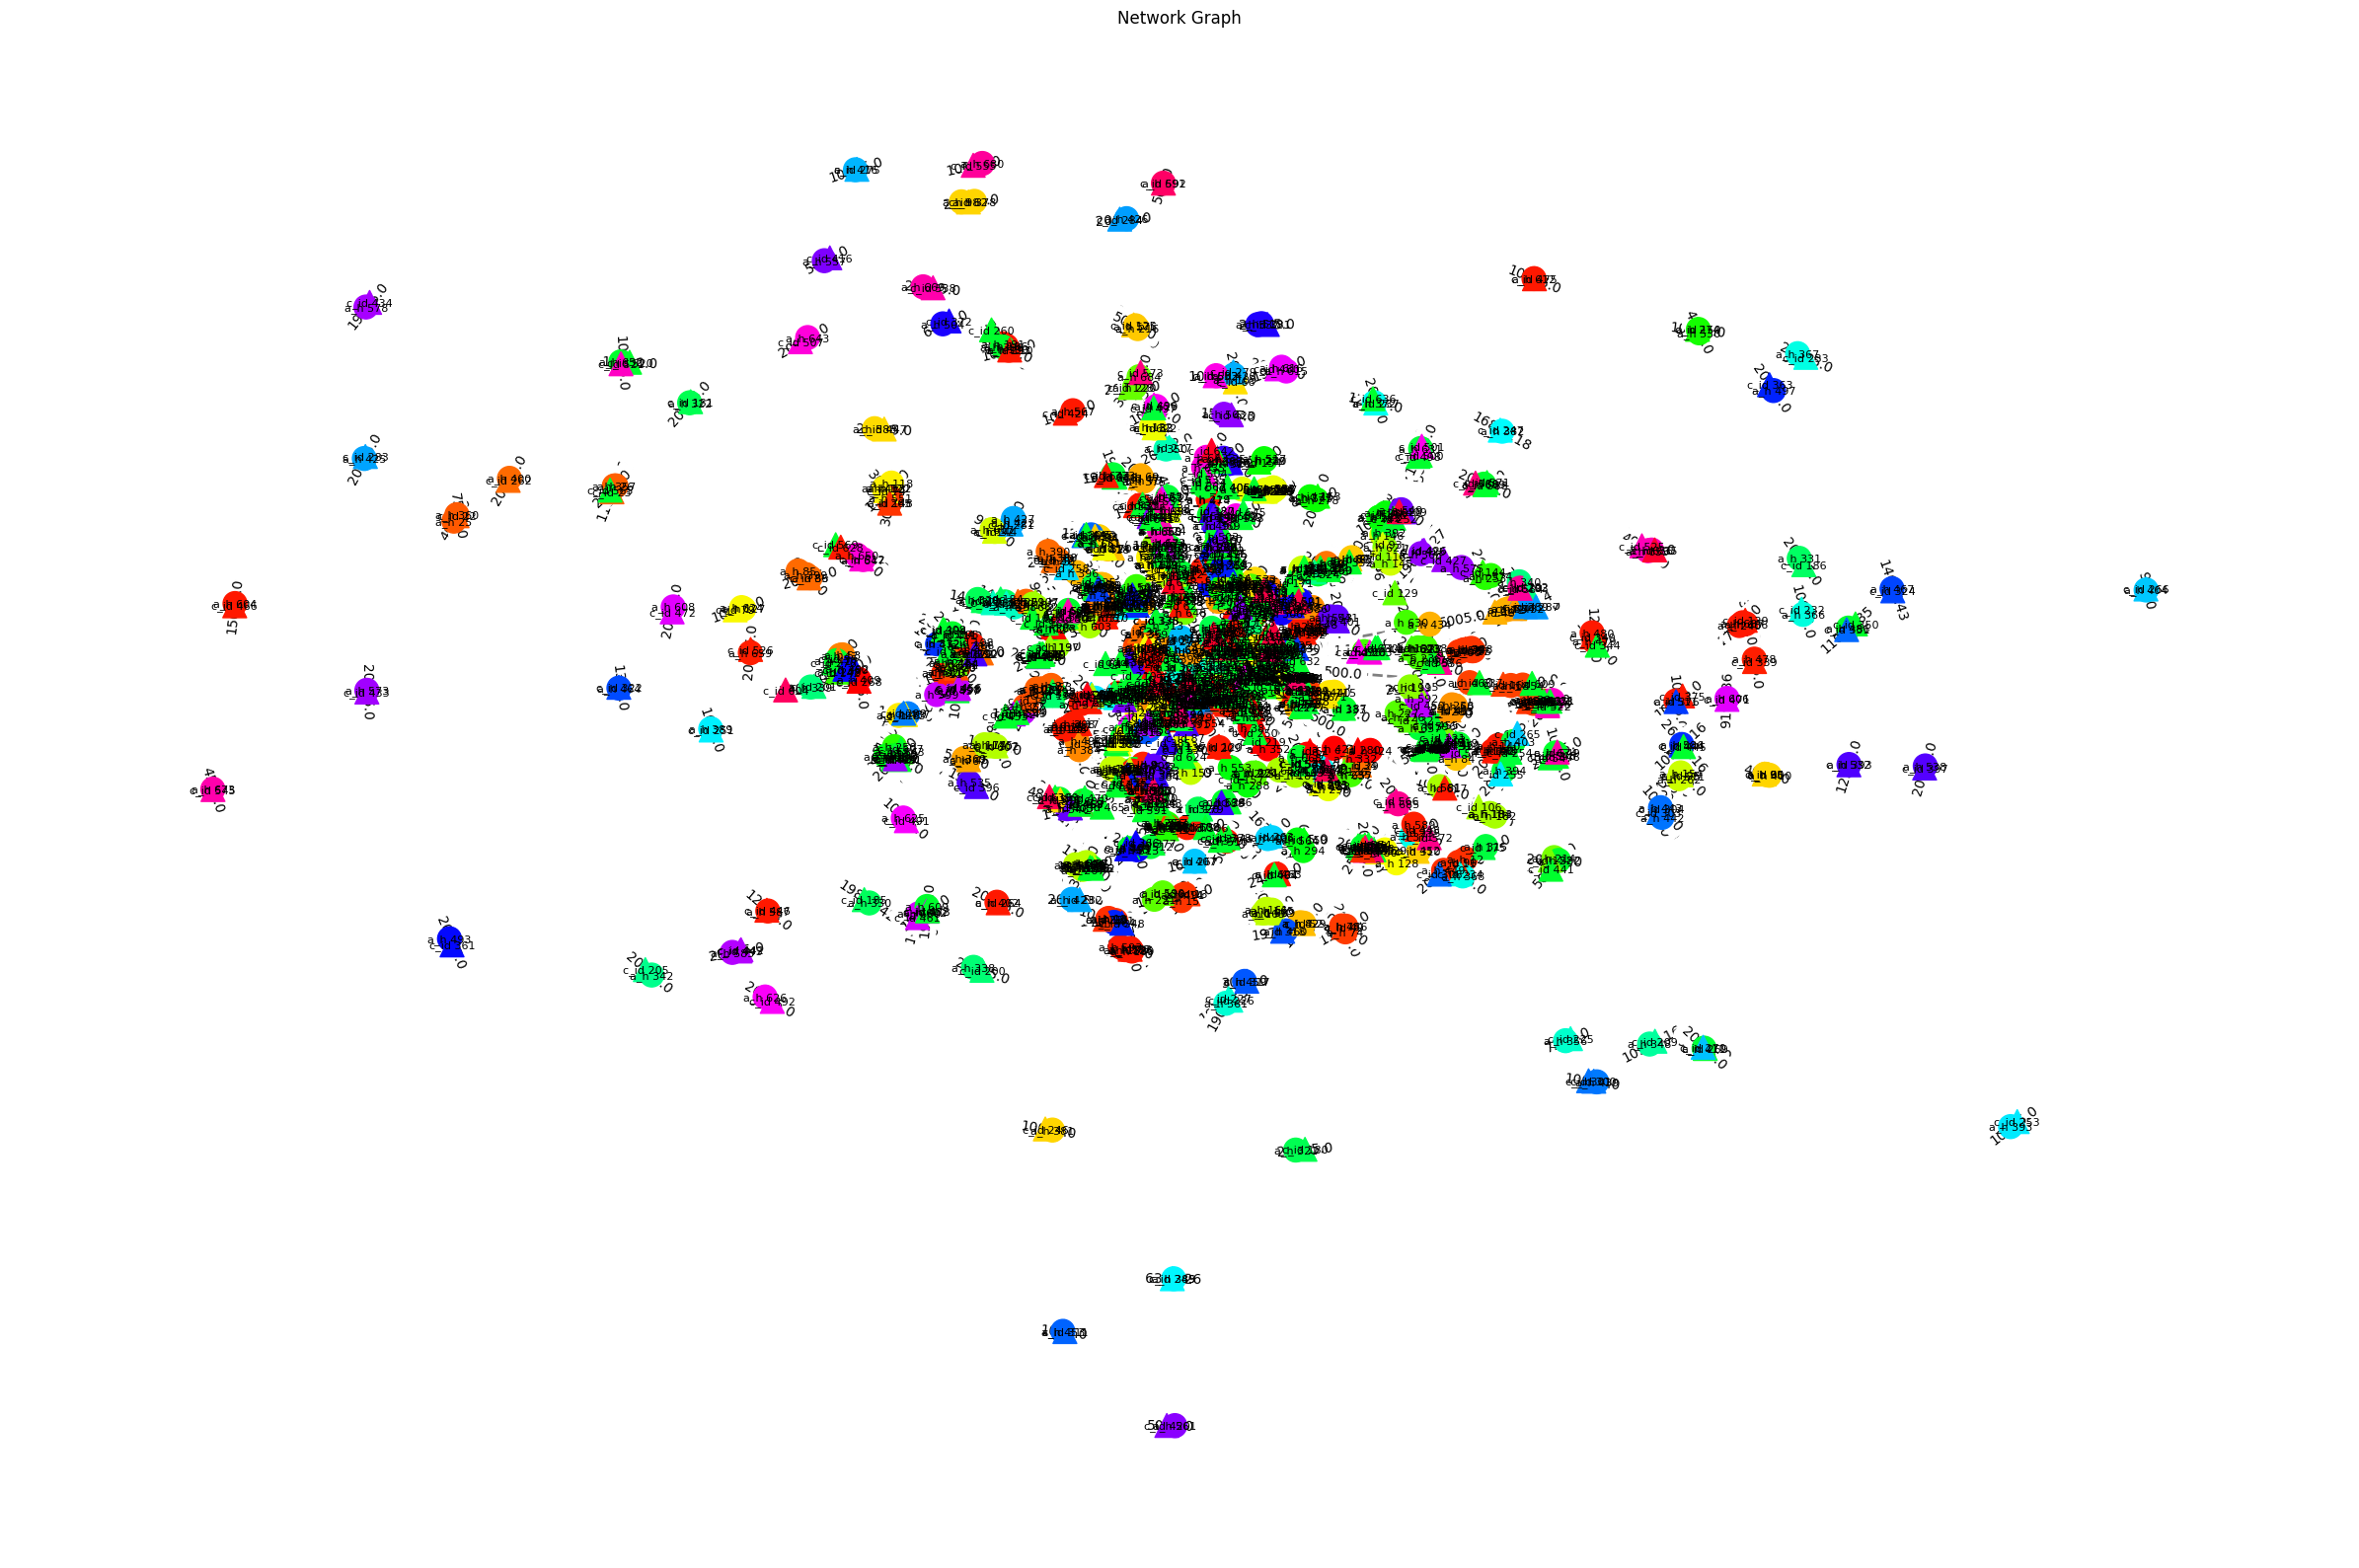

In [64]:
# Initialize the network graph
nodes = ['account_hash', 'customer_id']
edges = ['amount']

G = create_and_plot_network(df, nodes, edges, 'email')

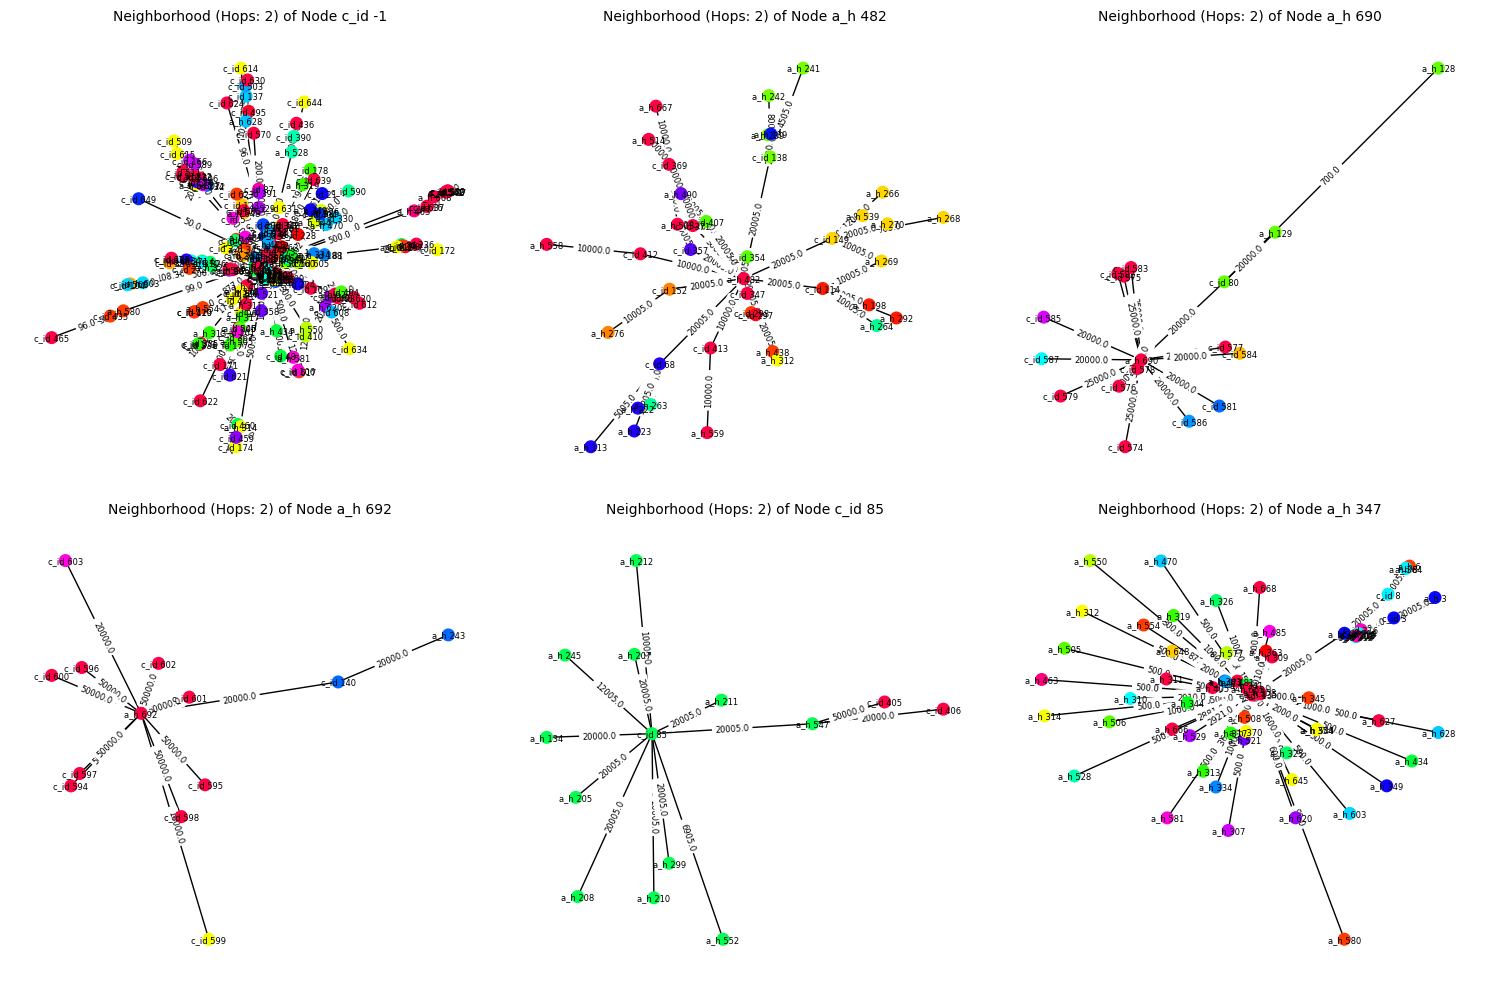

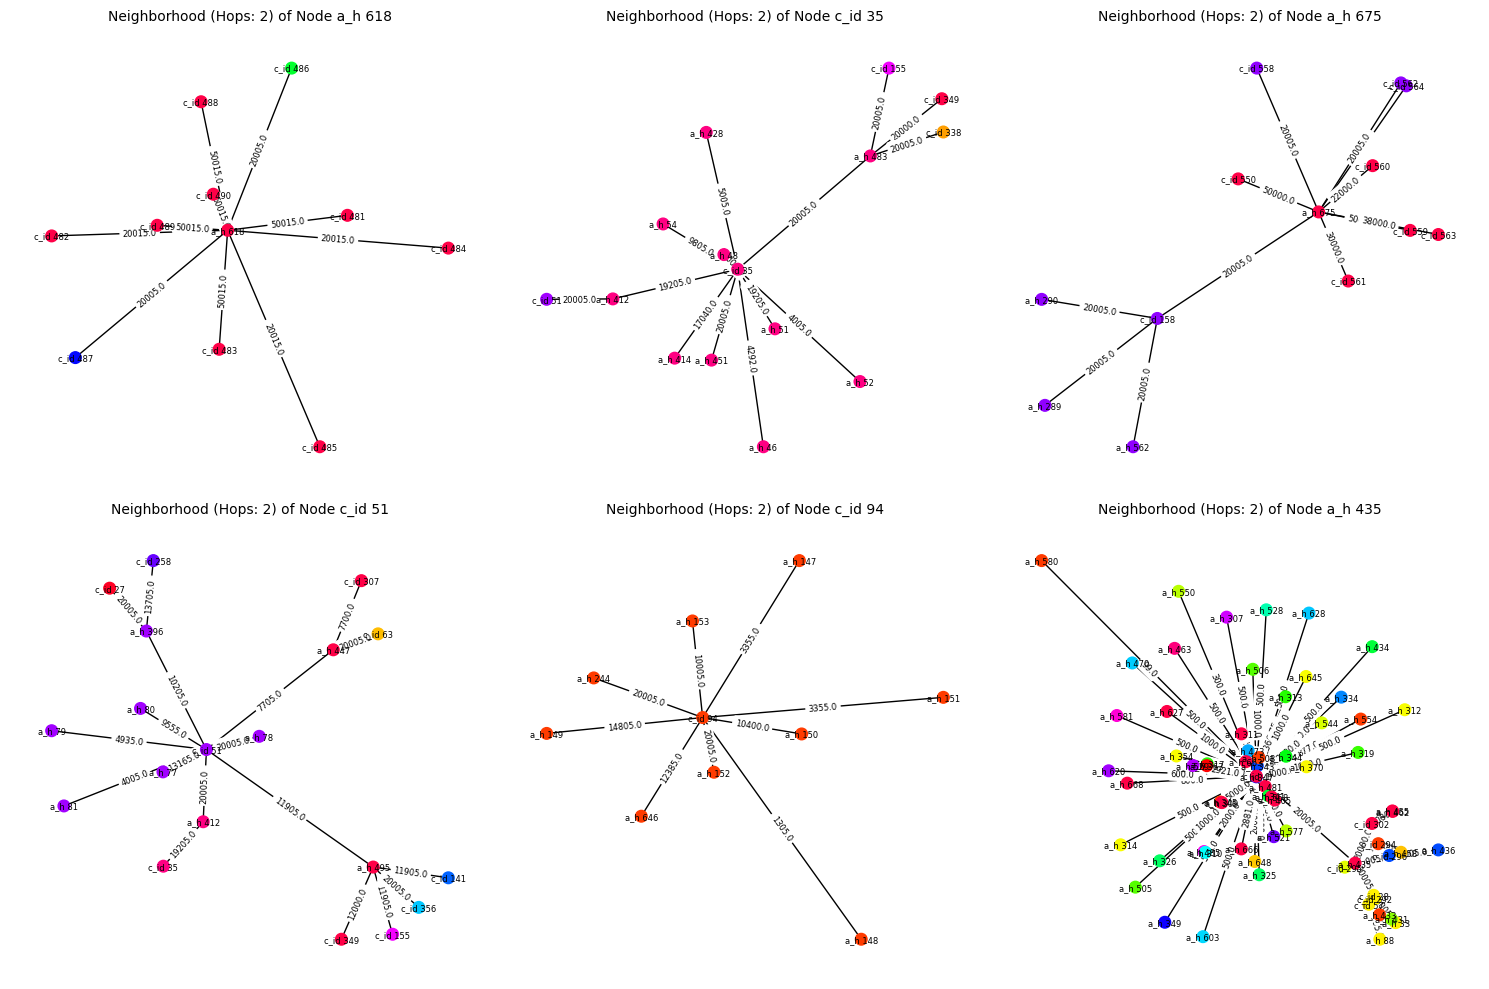

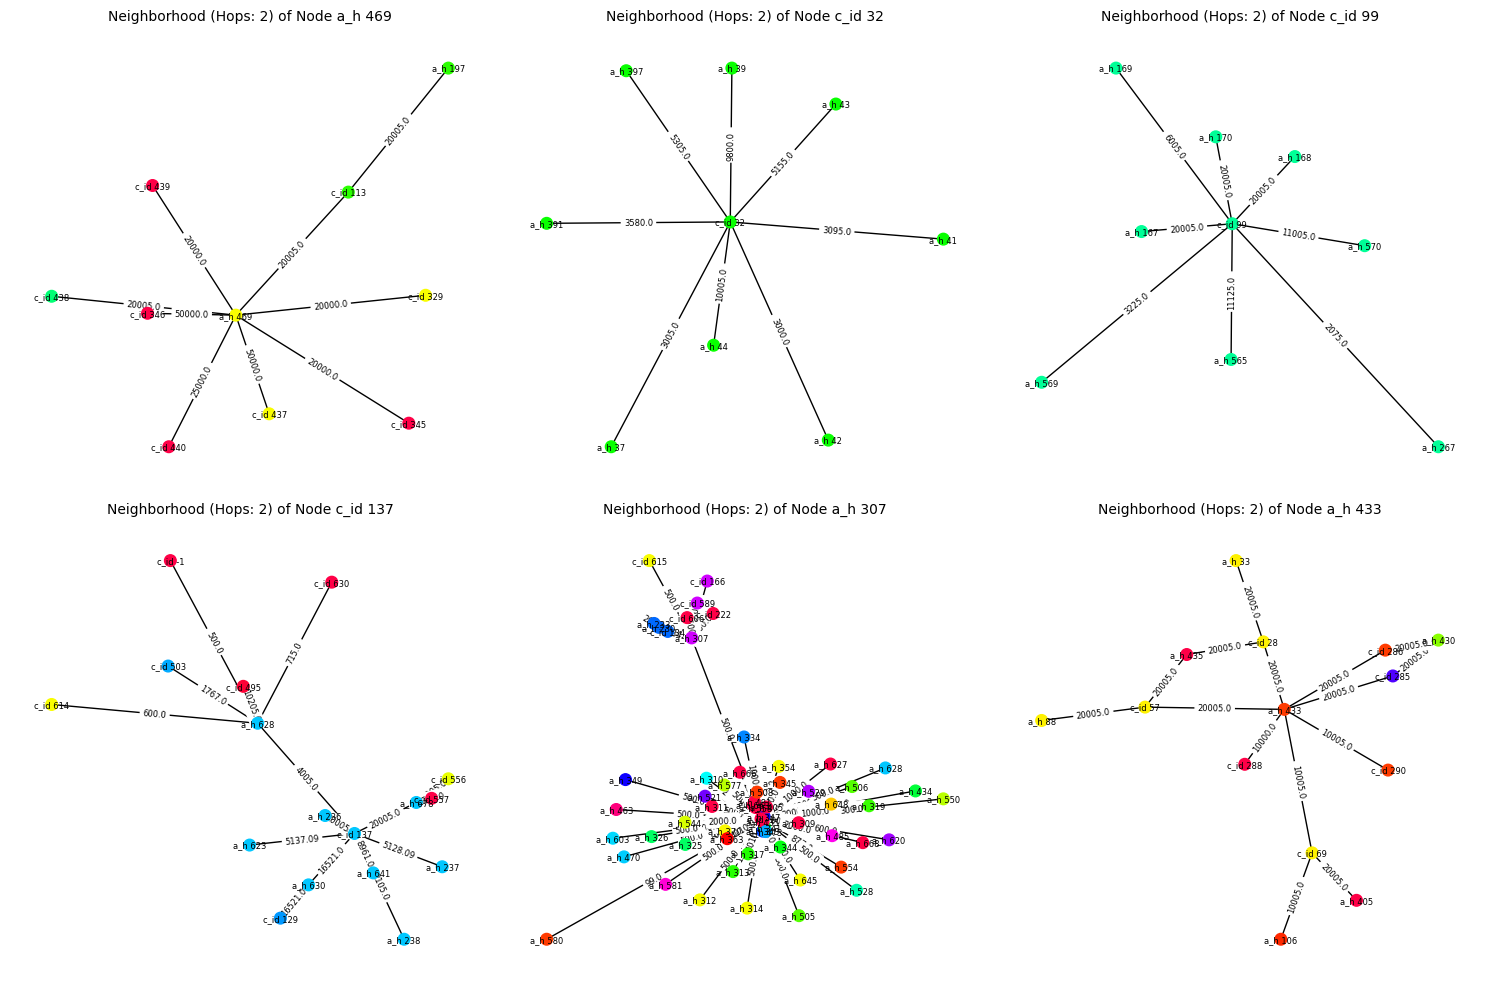

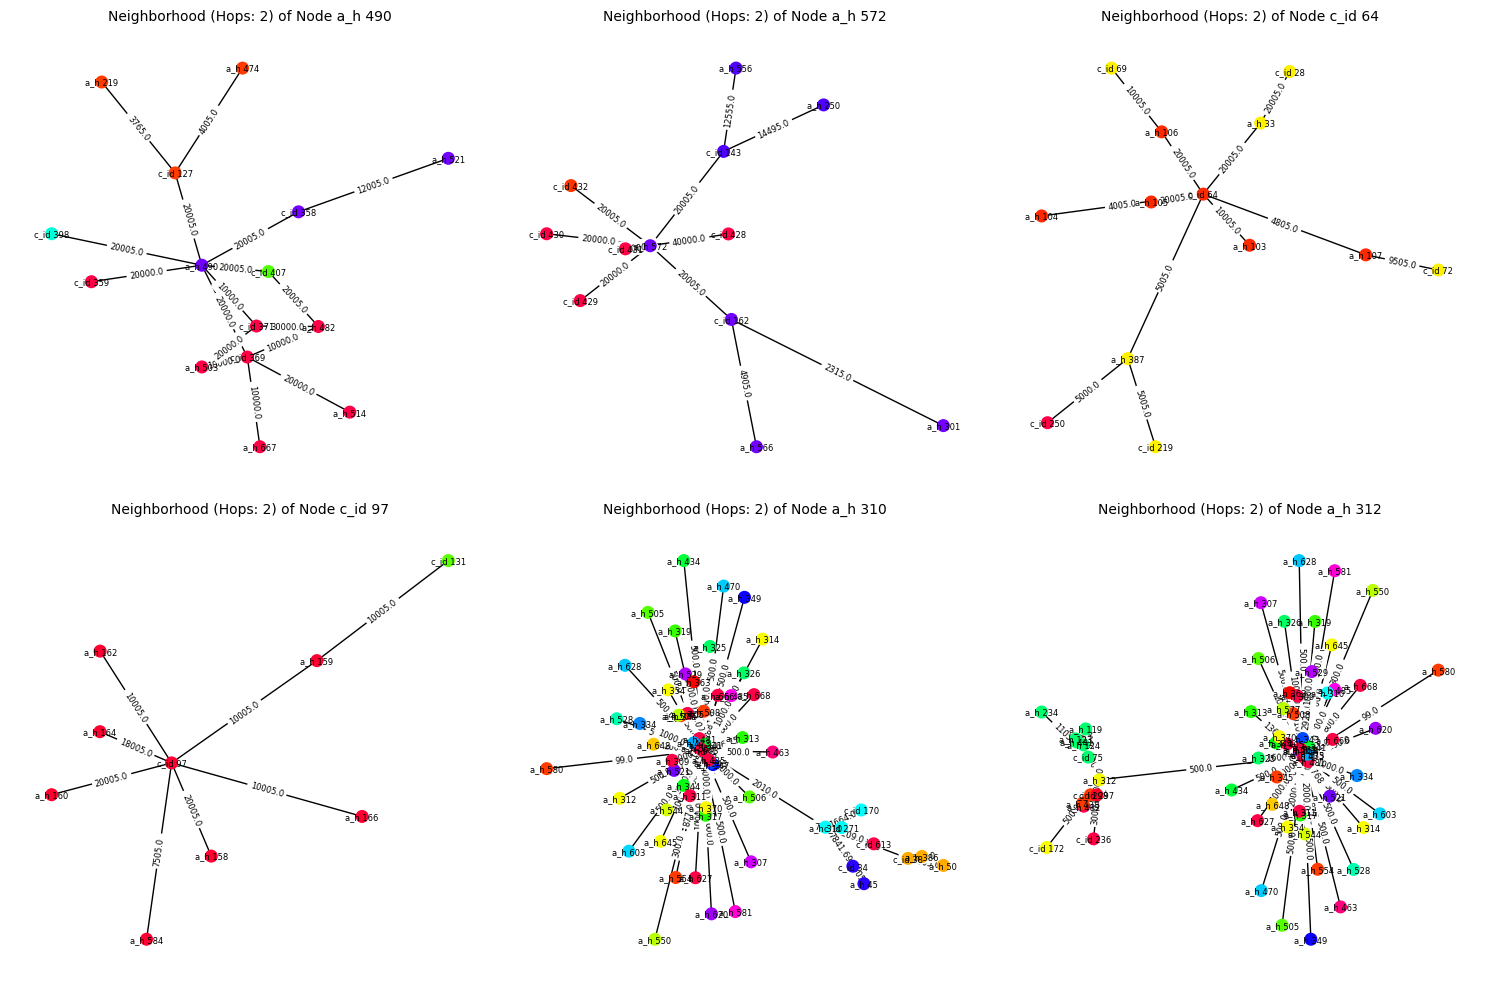

In [65]:
plot_subgraphs(G)